### Examine the Data

In [27]:
# Importing librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import statsmodels.api as sm

# define the plot size default
from pylab import rcParams
rcParams['figure.figsize'] = (12,5)

# load specific forecasting tools
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import mse,rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")



In [28]:

# Read the dataset
df_raw = pd.read_csv('waterTank_valueFlip_ctrl.csv', index_col=0, header=0, parse_dates=True)
df_raw.index.freq = 'MS'

df_raw.head()


,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
Time,,,,,,,
0.00,1.000000e-06,0.000000e+00,0,0.0,0,0.0,0.0
0.05,6.890000e-07,3.110000e-07,0,0.0,0,0.0,0.0
0.10,3.333928e-03,4.050000e-07,1,0.0,0,0.0,0.0
0.15,5.448433e-02,8.850002e-03,1,0.0,0,0.0,0.0
0.20,7.717051e-02,2.949715e-02,0,0.0,0,0.0,0.0


In [29]:
df_raw.isna().sum()

Tank1WaterLevel    0
Tank2WaterLevel    0
Tank1InFlow        0
Tank2OutFlow       0
wt3_valve          0
Tank3OutFlow       0
Tank2.level        0
dtype: int64

### Plot the source data

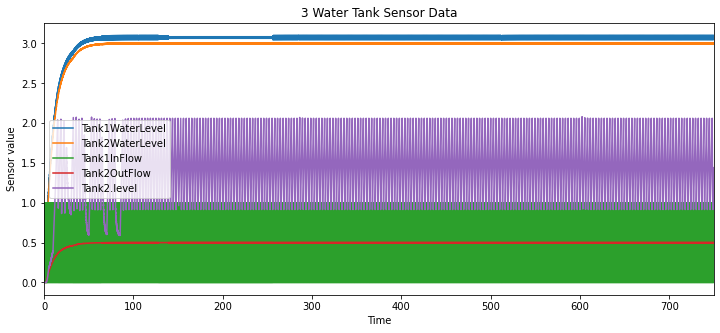

In [30]:
# ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
title = '3 Water Tank Sensor Data'
ylabel = 'Sensor value'
xlabel = ''
ax = df_raw['Tank1WaterLevel'].plot(legend=True, title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
df_raw['Tank2WaterLevel'].plot(legend=True)
df_raw['Tank1InFlow'].plot(legend=True)
df_raw['Tank2OutFlow'].plot(legend=True)

df_raw['Tank2.level'].plot(legend=True)
plt.show()

In [31]:
# Augmented Dickey-Fuller Test
def adf_test(series, title=''):
    '''
    Hypothesis Test for Stationarity
    Pass in a time series and an optional title, return an ADF report
    '''
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC')
    labels = ['ADF test statistics','p-value','#lags','#observations'] # use help(adfuller) to understand why these labels are chosen
    
    outcome = pd.Series(result[0:4],index=labels)
    
    for key,val in result[4].items():
        outcome[f'critical value ({key})'] = val
        
    print(outcome.to_string()) # this will not print the line 'dtype:float64'
    
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis') # Ho is Data is not stationary, check help(adfuller)
        print('Reject the null hypothesis')
        print('Data is Stationary')
    else:
        print('Weak evidence against the Null hypothesis')
        print('Fail to reject the null hypothesis')
        print('Data has a unit root and is non stationary')

In [32]:
adf_test(df_raw['Tank1WaterLevel'])

Augmented Dickey-Fuller Test: 
ADF test statistics    -1.325979e+01
p-value                 8.443583e-25
#lags                   4.200000e+01
#observations           1.495800e+04
critical value (1%)    -3.430787e+00
critical value (5%)    -2.861733e+00
critical value (10%)   -2.566873e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


Take the first order difference of the entire dataframe and re-run the dickey fuller test

In [33]:
# All the correlated features are stationary.
df_raw.head()

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
Time,,,,,,,
0.00,1.000000e-06,0.000000e+00,0,0.0,0,0.0,0.0
0.05,6.890000e-07,3.110000e-07,0,0.0,0,0.0,0.0
0.10,3.333928e-03,4.050000e-07,1,0.0,0,0.0,0.0
0.15,5.448433e-02,8.850002e-03,1,0.0,0,0.0,0.0
0.20,7.717051e-02,2.949715e-02,0,0.0,0,0.0,0.0


### Normalisation of the dataset

In [34]:
# def normalise_timeseries(data):
#     # Calculate the mean and standard deviation for each feature
#     means = np.mean(data, axis=0)
#     stds = np.std(data, axis=0)
    
#     # Normalise each feature using standard deviation
#     normalised_data = (data - means) / stds
    
#     return pd.DataFrame(normalised_data), means, stds

In [35]:
# Read the mean and std used for normalising the golden model
var_df = pd.read_csv("norm_var.csv", index_col=0)
old_means, old_stds = var_df["0"], var_df["1"]

def normalise_series(data, means, stds):
    normalised_data = (data - means) / stds
    return pd.DataFrame(normalised_data)


def denormalise_timeseries(data, means, stds):
    denormalised_data = (data * stds) + means
    return pd.DataFrame(denormalised_data)


normalised_data = normalise_series(df_raw, old_means, old_stds)

In [36]:
df = normalised_data

In [37]:
df

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
Time,,,,,,,
0.00,-13.751169,-13.647795,-1.001251,-11.718138,-0.58372,-0.563189,-4.102034
0.05,-13.751171,-13.647793,-1.001251,-11.718138,-0.58372,-0.563189,-4.102034
0.10,-13.736104,-13.647793,0.998751,-11.718138,-0.58372,-0.563189,-4.102034
0.15,-13.504895,-13.607095,0.998751,-11.718138,-0.58372,-0.563189,-4.102034
0.20,-13.402350,-13.512143,-1.001251,-11.718138,-0.58372,-0.563189,-4.102034
...,...,...,...,...,...,...,...
749.80,0.227724,0.167719,-1.001251,0.158064,-0.58372,-0.563189,-0.304058
749.85,0.131271,0.173739,-1.001251,0.175378,-0.58372,-0.563189,-0.247394
749.90,0.025990,0.142666,-1.001251,0.157702,-0.58372,-0.563189,-0.162263


In [38]:
# Train Test Split
nobs = 3000
train = df.iloc[:-nobs]
test = df.iloc[-nobs:]
len(train), len(test)

(12001, 3000)

### VAR Model Order Selection

In [39]:
# from statsmodels.tsa.vector_ar.var_model import VAROrderSelection
# Perform order selection using auto-arima
model = VAR(train)
# Select the best order based on a specific criterion (e.g. AIC, BIC)
selected_order = model.select_order()
# Get the selected order (lag length)
order = selected_order.selected_orders['aic']
min_aic_index = order
print('Order {0} has the least AIC value. Let us select p = {0} in the modelling'.format(min_aic_index))

Order 40 has the least AIC value. Let us select p = 40 in the modelling


In [40]:
# p = [1,2,3,4,5,6,7] # try with list of 7 p values
# p = list(range(1,20))
# aic, bic = [], []
# for i in p:
#     model = VAR(train)
#     results = model.fit(i)
#     aic.append(results.aic)
#     bic.append(results.bic)
#     print(f'VAR Order {i}')
#     print('AIC: {}'.format(results.aic))
#     print('BIC: {}'.format(results.bic))
#     print()

# min_aic = min(aic)
# min_aic_index = aic.index(min_aic) + 1
# min_bic = min(bic)
# min_bic_index = bic.index(min_bic) + 1
# print('Order {0} has the least AIC value. Let us select p = {0} in the modelling'.format(min_aic_index))


In [41]:
# let's confirm that both the variables are included in the model
model.endog_names

['Tank1WaterLevel',
 'Tank2WaterLevel',
 'Tank1InFlow',
 'Tank2OutFlow',
 'wt3_valve',
 'Tank3OutFlow',
 'Tank2.level']

In [42]:
from IPython.display import Markdown as md
md("Fit the VAR( {{}} ) model".format(min_aic_index))

Fit the VAR( {} ) model

### Fit the VAR {{min_aic_index}}  model

In [43]:
min_aic_index

40

In [44]:
results = model.fit(min_aic_index)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 19, Jun, 2023
Time:                     12:22:44
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -66.5374
Nobs:                     11961.0    HQIC:                  -67.3449
Log likelihood:           288358.    FPE:                3.76220e-30
AIC:                     -67.7526    Det(Omega_mle):     3.19777e-30
--------------------------------------------------------------------
Results for equation Tank1WaterLevel
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -0.003341         0.000341           -9.810           0.000
L1.Tank1WaterLevel          0.397821         0.011732           33.909           0.000
L1.Tank2WaterLevel        

### Predict the next 20 values

In [45]:
# For predictions, VAR model uses .forecast() instead of predictions.
lag_order = results.k_ar
lag_order

40

In [46]:
df.head()

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
Time,,,,,,,
0.00,-13.751169,-13.647795,-1.001251,-11.718138,-0.58372,-0.563189,-4.102034
0.05,-13.751171,-13.647793,-1.001251,-11.718138,-0.58372,-0.563189,-4.102034
0.10,-13.736104,-13.647793,0.998751,-11.718138,-0.58372,-0.563189,-4.102034
0.15,-13.504895,-13.607095,0.998751,-11.718138,-0.58372,-0.563189,-4.102034
0.20,-13.402350,-13.512143,-1.001251,-11.718138,-0.58372,-0.563189,-4.102034


In [47]:
steps = 20
# z = results.forecast(y=train.values[-lag_order:], steps = 20)
z = results.forecast(y=train.values[-lag_order:], steps=steps)
z

array([[ 0.22764055,  0.16773551, -1.00002875,  0.15806846,  1.64180835,
         1.02648487, -1.37081865],
       [ 0.09216887,  0.16724749, -1.00783763,  0.17456389, -0.56699786,
         0.88014356, -1.5014571 ],
       [ 0.02625302,  0.14257503, -0.98974875,  0.15761437, -0.58747167,
        -0.54837883, -1.45560583],
       [ 0.16557   ,  0.12353809,  1.00771316,  0.12648152, -0.57771975,
        -0.5718904 , -1.37089589],
       [ 0.23932691,  0.1409728 ,  0.99506985,  0.13373285, -0.59268079,
        -0.55993177, -1.31271758],
       [ 0.17568199,  0.17463678, -1.00729739,  0.16984578, -0.57236272,
        -0.58128135, -1.22689307],
       [ 0.09214437,  0.16711889, -0.99491138,  0.17454572, -0.58655782,
        -0.54606519, -1.17005519],
       [ 0.0691354 ,  0.12953886,  1.00099703,  0.14379516, -0.5853894 ,
        -0.57378401, -1.08521524],
       [ 0.16571293,  0.12375501,  0.9810855 ,  0.12663333, -0.5862823 ,
        -0.56566464, -1.0265005 ],
       [ 0.27034116,  0.1546

In [48]:
test

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
Time,,,,,,,
600.05,0.227723,0.167718,-1.001251,0.158063,1.713149,1.020218,-1.370958
600.10,0.092377,0.167225,-1.001251,0.174568,-0.583720,0.939788,-1.509683
600.15,0.025989,0.142665,-1.001251,0.157701,-0.583720,-0.563189,-1.465045
600.20,0.165422,0.123576,0.998751,0.126509,-0.583720,-0.563189,-1.380027
600.25,0.239055,0.140813,0.998751,0.133594,-0.583720,-0.563189,-1.323489
...,...,...,...,...,...,...,...
749.80,0.227724,0.167719,-1.001251,0.158064,-0.583720,-0.563189,-0.304058
749.85,0.131271,0.173739,-1.001251,0.175378,-0.583720,-0.563189,-0.247394
749.90,0.025990,0.142666,-1.001251,0.157702,-0.583720,-0.563189,-0.162263


In [49]:
# idx = pd.date_range(start='1/1/2015', periods=12, freq='MS')
# df_forecast = pd.DataFrame(z, index=idx, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])
df_forecast = pd.DataFrame(z, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])
df_forecast[:5]

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
0,0.227641,0.167736,-1.000029,0.158068,1.641808,1.026485,-1.370819
1,0.092169,0.167247,-1.007838,0.174564,-0.566998,0.880144,-1.501457
2,0.026253,0.142575,-0.989749,0.157614,-0.587472,-0.548379,-1.455606
3,0.165570,0.123538,1.007713,0.126482,-0.577720,-0.571890,-1.370896
4,0.239327,0.140973,0.995070,0.133733,-0.592681,-0.559932,-1.312718


### Plot the results

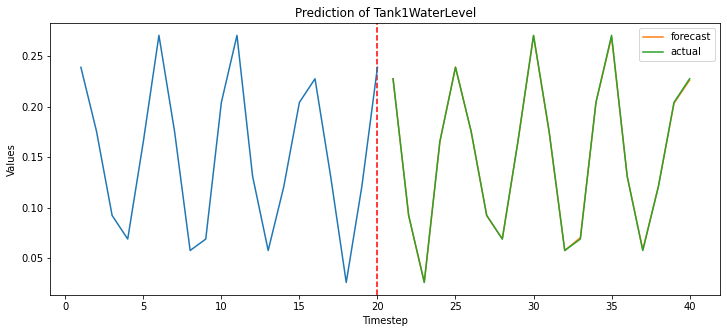

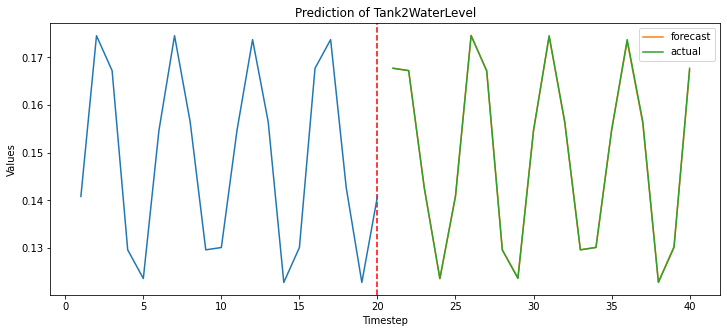

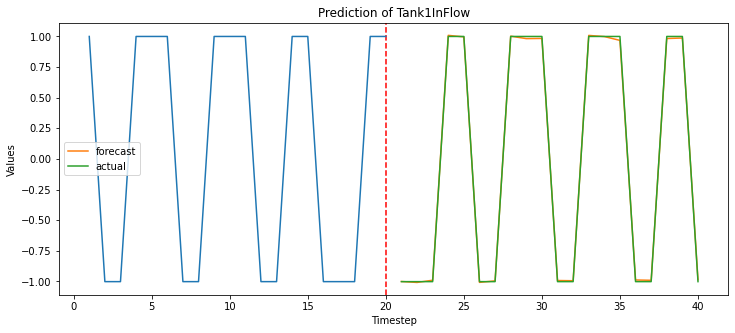

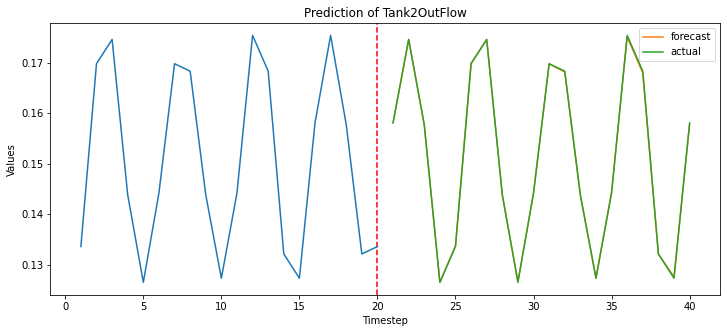

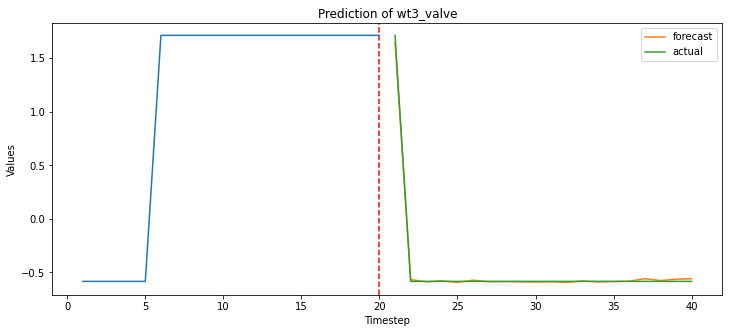

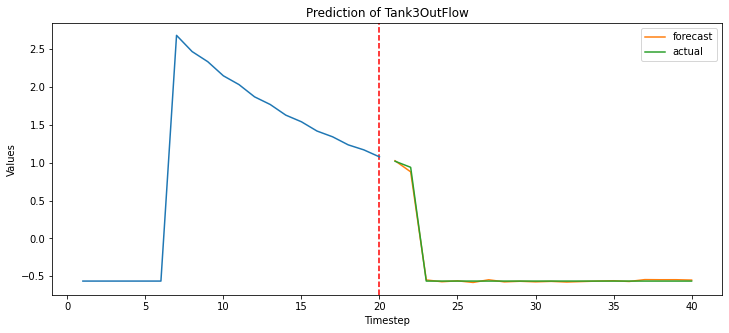

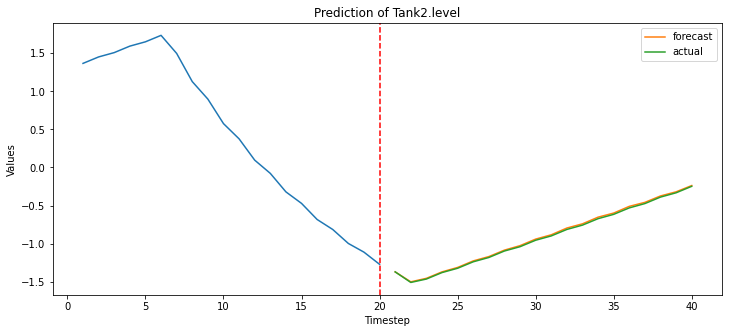

In [50]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
# input_length = 20
# for i in range(len(attr)):
#     title = "Prediction of {}".format(attr[i])
#     actual_index = pd.Index(list(range(1, input_length+1)))
#     actual = train.iloc[-input_length:,:]
    
#     index = pd.Index(list(range(lag_order, lag_order + steps)))
#     actual = actual.set_index(actual_index)
#     pred = df_forecast.set_index(index)
#     actual_test = test.iloc[:lag_order+1,:].set_index(index)
#     # draw a vertical line at x=19
#     plt.axvline(x=lag_order, ls='--', color='red')
# #     pred = df_forecast
#     plt.title(title)
#     plt.xlabel("Timestep")
#     plt.ylabel("Values")
#     plt.plot(actual.iloc[:,i])
#     plt.plot(pred.iloc[:,i], label="forecast")
#     plt.plot(actual_test.iloc[:,i], label="actual")
#     plt.legend()
#     plt.show()
    


attr = list(pd.read_csv('waterTank_valueFlip_ctrl.csv').columns.values)[1:]
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
input_length = 20
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index = pd.Index(list(range(1,input_length+1)))
#     actual = train.iloc[-lag_order:,:] # CORRECT BEFORE EDITING
    actual = train.iloc[-input_length:,:]
    
#     index = pd.Index(list(range(lag_order, lag_order + steps))) # CORRECT BEFORE EDITING
    index = pd.Index(list(range(input_length+1, input_length + steps +1)))
    actual = actual.set_index(actual_index)
    pred = df_forecast.set_index(index)
    actual_test = test.iloc[:input_length,:].set_index(index)
    # draw a vertical line at x=20
#     plt.axvline(x=lag_order, ls='--', color='red') # CORRECT BEFORE EDITING
    plt.axvline(x=input_length, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual.iloc[:,i])
    plt.plot(pred.iloc[:,i], label="forecast")
    plt.plot(actual_test.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

### Model Evaluation

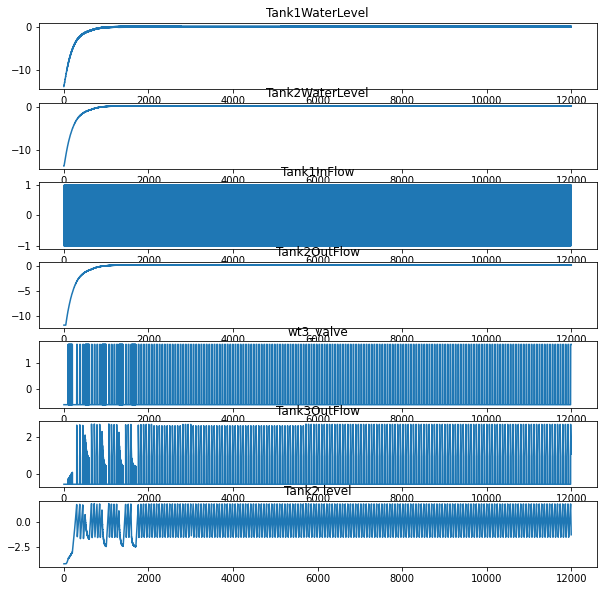

In [51]:
results.plot();

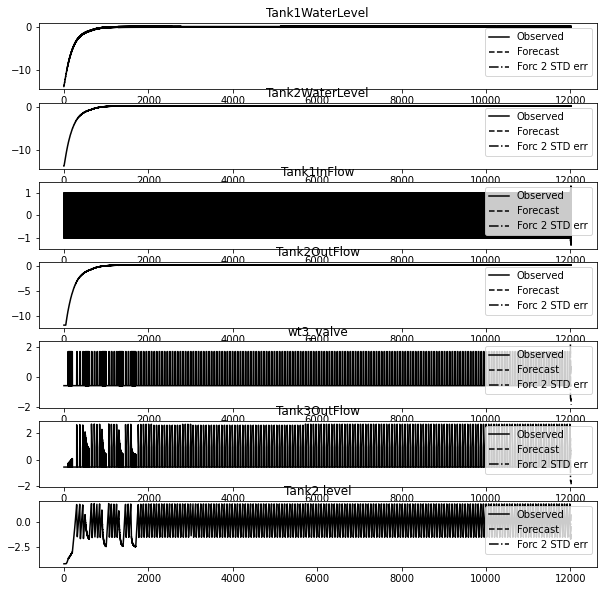

In [52]:
results.plot_forecast(20);

In [53]:
len(df_forecast)

20

In [54]:
len(df['Tank1WaterLevel'].iloc[:steps])

20

### Model Evaluation

In [55]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSE = []
for feat in attr:
    RMSE.append(rmse(pred[feat].iloc[:steps], actual_test[feat]))

print(RMSE) 

[0.000683953671046422, 0.000186424743104974, 0.012614616291053688, 0.00016120174905580263, 0.019448434124405146, 0.017581479492145557, 0.013932007959823264]


### Save the model

In [56]:
# Serialize andsave the model

with open('var_ctrl_valueFlip.pkl', 'wb') as f:
    pickle.dump(results, f)
print("Model saved!")

Model saved!


### Define the faulty data

In [57]:
faulty_data = pd.read_csv('test_fault.csv', index_col=0, header=0, parse_dates=True)

faulty_data.index.freq = 'MS'
num_obs = 3000

# train_faulty = faulty_data.iloc[-num_obs:]
# test_faulty = faulty_data.iloc[:-num_obs]

train_faulty = faulty_data.iloc[:-num_obs]
test_faulty = faulty_data.iloc[-num_obs:]
len(train_faulty), len(test_faulty)

(12001, 3000)

### Load the model and reconstruct VAR

In [58]:
with open('var_ctrl_valueFlip.pkl', 'rb') as f:
    params = pickle.load(f)
    
valueFlip_model = sm.tsa.VAR(train)
valueFlip_model.params = params
valueFlip_model_fit = valueFlip_model.fit(min_aic_index)

valueFlip_model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 19, Jun, 2023
Time:                     12:22:48
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -66.5374
Nobs:                     11961.0    HQIC:                  -67.3449
Log likelihood:           288358.    FPE:                3.76220e-30
AIC:                     -67.7526    Det(Omega_mle):     3.19777e-30
--------------------------------------------------------------------
Results for equation Tank1WaterLevel
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -0.003341         0.000341           -9.810           0.000
L1.Tank1WaterLevel          0.397821         0.011732           33.909           0.000
L1.Tank2WaterLevel        

### Forecast using faulty data

In [59]:
# Use the loaded model to make predictions or perform other analyses
forecast = valueFlip_model_fit.forecast(y=train_faulty.values[-lag_order:], steps=20)
# forecast = golden_model_fit.forecast(params, start=len(train), end=len(train)+10)
forecast

array([[  2.82357398,   3.07688376, -11.2378845 ,   1.40348328,
         -0.96437569,   2.6643491 ,  25.74430073],
       [  3.01782521,   3.02563847,  10.16082633,   2.15389177,
         -4.28744289,   1.22234067,  25.64575249],
       [  2.92699675,   3.02727168,  -3.24955133,   2.78717565,
         -2.77638412,  -2.92733075,  25.67713751],
       [  2.88475829,   2.9855695 ,  -7.08194804,   2.96221858,
         -4.34472789,   0.90277119,  25.84069878],
       [  2.60840678,   2.97948167,  -0.57497286,   3.06703634,
         -1.05052272,  -1.26324732,  25.79691352],
       [  3.03855053,   2.8831952 ,   3.30868502,   2.94945893,
         -2.20295098,   3.98027845,  25.47253097],
       [  3.49062997,   2.95001961,   5.4056299 ,   3.00756155,
          4.70281105,   4.09482829,  24.77955853],
       [  2.91817501,   3.07411613,  -8.86583196,   3.12243544,
          3.05671415,   9.30874097,  23.79649858],
       [  2.3936812 ,   3.0419939 , -11.14267931,   3.13400987,
         12.5887

In [60]:
fault_forecast = pd.DataFrame(forecast, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])

attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index_f = pd.Index(list(range(lag_order)))
    actual_f = train_faulty.iloc[-lag_order:,:]
    
    index_f = pd.Index(list(range(lag_order, lag_order + steps)))
    actual_f = actual_f.set_index(actual_index_f)
    pred_f = fault_forecast.set_index(index_f)
    actual_test_f = test_faulty.iloc[:lag_order+1,:].set_index(index_f)
    # draw a vertical line at x=19
    plt.axvline(x=lag_order, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual_f.iloc[:,i])
    plt.plot(pred_f.iloc[:,i], label="forecast")
    plt.plot(actual_test_f.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

ValueError: Length mismatch: Expected 41 rows, received array of length 20

In [ ]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSEf = []
for feat in attr:
    RMSEf.append(rmse(df[feat].iloc[:steps], fault_forecast[feat]))

print(RMSEf)

### Increasing the duration of the faults

In [ ]:
faulty_data_extend = pd.read_csv('test_extend.csv', index_col=0, header=0, parse_dates=True)

faulty_data_extend.index.freq = 'MS'
num_obs = 3000

# train_faulty = faulty_data.iloc[-num_obs:]
# test_faulty = faulty_data.iloc[:-num_obs]

train_faulty_extend = faulty_data_extend.iloc[:-num_obs]
test_faulty_extend = faulty_data_extend.iloc[-num_obs:]
len(train_faulty_extend), len(test_faulty_extend)

In [ ]:
# Use the loaded model to make predictions or perform other analyses
forecast_extend = valueFlip_model_fit.forecast(y=train_faulty_extend.values[-lag_order:], steps=20)

In [ ]:
fault_forecast = pd.DataFrame(forecast_extend, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])

attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index_f = pd.Index(list(range(lag_order)))
    actual_f = train_faulty.iloc[-lag_order:,:]
    
    index_f = pd.Index(list(range(lag_order, lag_order + steps)))
    actual_f = actual_f.set_index(actual_index_f)
    pred_f = fault_forecast.set_index(index_f)
    actual_test_f = test_faulty.iloc[:lag_order+1,:].set_index(index_f)
    # draw a vertical line at x=19
    plt.axvline(x=lag_order, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual_f.iloc[:,i])
    plt.plot(pred_f.iloc[:,i], label="forecast")
    plt.plot(actual_test_f.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

In [ ]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSEf = []
for feat in attr:
    RMSEf.append(rmse(df[feat].iloc[:steps], fault_forecast[feat]))

print(RMSEf)

In [1]:
import keyword
print(keyword.kwlist)

['False', 'None', 'True', 'and', 'as', 'assert', 'async', 'await', 'break', 'class', 'continue', 'def', 'del', 'elif', 'else', 'except', 'finally', 'for', 'from', 'global', 'if', 'import', 'in', 'is', 'lambda', 'nonlocal', 'not', 'or', 'pass', 'raise', 'return', 'try', 'while', 'with', 'yield']


In [3]:
12-3

9